In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from itertools import cycle
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AffinityPropagation, OPTICS, cluster_optics_dbscan
from gensim.models.keyedvectors import KeyedVectors

sns.set_style('darkgrid')

# Read code vectors
DATASET_NAME = "python-small"
MODEL_NAME = "py_model"
token_embeddings = f'./data/{DATASET_NAME}/tokens.txt'
target_embeddings = f'./data/{DATASET_NAME}/targets.txt'

# Load code vectors and labels
vectors = pd.read_csv(f'./data/{DATASET_NAME}/{DATASET_NAME}.test.c2v.vectors', sep=" ", header=None)
labels = pd.read_csv(f'./data/{DATASET_NAME}/{DATASET_NAME}.test.c2v', sep=" ").iloc[:, 0]

embedding_shape = vectors.values.shape[1]

# Merge vectors and labels, create numerical labels
df = vectors.assign(label=labels)
df.dropna(inplace=True)

# Count number of occurrences for each label
df['count'] = df.groupby('label')['label'].transform('count')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,376,377,378,379,380,381,382,383,label,count
0,-0.725653,-0.683152,0.741892,-0.776258,0.261242,0.259904,0.456306,0.296833,0.300850,0.538582,...,-0.146298,0.244202,-0.761943,-0.869466,-0.236046,0.917939,-0.329328,0.544497,|wrap|indexin|verbose,1
1,0.516459,-0.422582,0.978825,0.039943,0.125243,0.161318,-0.917524,0.667879,-0.343896,0.690732,...,-0.254368,-0.378047,0.625265,-0.331459,0.470658,0.641745,0.528675,0.190506,fast|norm,1
2,-0.725414,0.506977,-0.476344,-0.658100,-0.147991,0.541668,0.520115,0.764436,0.806277,-0.881450,...,0.921764,0.799426,0.635653,0.937958,0.602502,0.565932,-0.535572,-0.695010,asymptotic|decay,1
3,-0.875259,0.779345,0.054250,0.024057,-0.685877,0.631243,0.840025,0.433036,-0.298992,0.029438,...,-0.235626,0.972460,0.472054,0.969310,0.870043,0.412882,0.514801,-0.904052,init,3935
4,0.178146,0.575227,-0.396287,-0.458783,0.320927,-0.048418,0.426695,0.484011,0.740813,-0.822030,...,0.259194,-0.857919,-0.471130,-0.732099,-0.480121,0.231000,-0.250182,0.630780,get|weights,4


In [2]:
# Similarities and Analogies
w2v = KeyedVectors.load_word2vec_format(token_embeddings, binary=False)
t2v = KeyedVectors.load_word2vec_format(target_embeddings, binary=False)

token_vocab = w2v.vocab.keys()
target_vocab = t2v.vocab.keys()
print(f"Loaded embeddings for {len(token_vocab)} tokens and {len(target_vocab)} targets.")


# prints libraries in your model having 'name' as a substring
def find_library(name, vocab):
    result = []
    for l in vocab:
        if name in l:
            result.append(l)
    return result

Loaded embeddings for 54017 tokens and 21358 targets.


In [3]:
print(t2v.most_similar('evaluate'))
# print(find_library('evaluate', target_vocab))

[('evaluate|update', 0.29020339250564575), ('fill|feed|dict', 0.2887274920940399), ('calculate|roc', 0.27780377864837646), ('test', 0.2513439357280731), ('construct|feed|dict|semi', 0.25069302320480347), ('train|gluon', 0.24894818663597107), ('PrepareData', 0.24097338318824768), ('sample', 0.231096088886261), ('get|face|feature|batch', 0.22910675406455994), ('train|model', 0.22827038168907166)]


In [16]:
# Randomly select k frequently occuring labels to consider for analysis
# k = 5
# Only consider labels that are "frequently" occuring
# df_subset = df[(df['count'] >= 100) & (df['count'] <= 3000)]
# np.random.seed(20) #31
# cats = np.random.choice(df_subset.label.unique(), size=k, replace=False)
# df_subset = df_subset[df_subset.label.isin(cats)]

# manually choose
cats = ['predict', 'evaluate', 'save', 'update', 'process','preprocess', 'postprocess', 'transform', 'load', 'read']
k = len(cats)
df_subset = df[df.label.isin(cats)]

# Assign numerical values for each category
df_subset.label = pd.Categorical(df_subset.label)
df_subset['category'] = df_subset.label.cat.codes
unique_labels = dict( enumerate(df_subset['label'].cat.categories ) )
print(f"Unique labels:{unique_labels}\nNumber of samples {len(df_subset)}")

# Use to limit the number of samples (if necessary for computational reasons)
# rndperm = np.random.permutation(df.shape[0])
# N = 10000
# df_subset = df_subset.loc[rndperm[:N],:].copy()

data_subset = df_subset.iloc[:, 0:embedding_shape-1].values

Unique labels:{0: 'evaluate', 1: 'load', 2: 'postprocess', 3: 'predict', 4: 'preprocess', 5: 'process', 6: 'read', 7: 'save', 8: 'transform', 9: 'update'}
Number of samples 764


/home/marcus/anaconda3/envs/scc/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/marcus/anaconda3/envs/scc/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


## Check for similarities and analogies

In [17]:
df_subset.sort_values('category').groupby('label').first()

,0,1,2,3,4,5,6,7,8,9,...,376,377,378,379,380,381,382,383,count,category
label,,,,,,,,,,,,,,,,,,,,,
evaluate,0.816033,0.934662,-0.545668,0.435630,-0.059193,0.881107,0.371922,-0.799325,-0.355980,-0.760686,...,-0.615699,0.072433,0.858650,-0.006588,0.040229,-0.880239,-0.103929,-0.415121,56,0
load,0.577359,0.358906,-0.730670,0.736195,-0.674212,0.814426,0.698731,-0.299576,-0.557856,0.151290,...,0.247236,-0.048601,0.017081,0.343655,-0.537406,-0.635394,-0.501148,-0.502726,100,1
postprocess,-0.865800,0.725897,-0.868253,0.478965,-0.463976,0.045845,0.483561,0.571730,-0.505700,-0.853550,...,-0.200268,0.957850,-0.915010,0.954296,0.424330,0.569401,0.794566,-0.940162,6,2
predict,0.847460,0.088208,-0.897629,0.512087,-0.966900,0.911010,0.713831,-0.529517,0.850476,-0.503573,...,0.978302,-0.096431,0.666454,0.905477,0.018071,-0.764889,0.586911,-0.625366,132,3
preprocess,-0.932204,0.980985,-0.991783,-0.570131,-0.990302,0.861484,0.974865,-0.905458,0.297515,-0.308789,...,-0.026243,0.988617,0.993440,0.359019,0.739637,-0.978939,-0.634531,-0.986702,26,4
process,-0.019212,0.870673,-0.817275,0.363608,0.622076,0.777055,0.757105,-0.045153,0.770035,-0.907459,...,-0.113758,-0.708391,-0.487528,-0.801647,-0.811837,-0.460584,-0.781447,0.274308,17,5
read,-0.147491,-0.190197,-0.723855,-0.732626,-0.827361,0.624341,-0.776496,0.612740,0.816744,-0.221147,...,0.158546,-0.543578,0.882239,-0.536986,0.353687,0.439925,0.445639,0.624687,66,6
save,-0.703704,0.403827,-0.967009,-0.322909,0.481484,0.234951,0.912378,-0.484739,-0.966066,-0.704934,...,-0.425980,0.948205,-0.841652,0.895005,0.006825,-0.437933,0.883253,0.326172,113,7
transform,-0.606913,-0.628950,-0.629707,-0.441442,-0.913232,0.396737,-0.145963,-0.369285,-0.242977,-0.757177,...,0.601604,0.209175,0.925224,0.515988,0.373234,0.433667,-0.099077,-0.160900,173,8


In [18]:
# Find similarities and analogies among the embedded targets (labels)
print(t2v.similarity('update', 'save'))
print(t2v.most_similar('preprocess'))

0.09763453
[('postprocess', 0.33173227310180664), ('process', 0.33008721470832825), ('get|async|response', 0.31836751103401184), ('|build|word|embeddings', 0.29718971252441406), ('|preprocess', 0.29578274488449097), ('build|mock|groupby', 0.2781805098056793), ('wrapper', 0.26636335253715515), ('get|instances', 0.2591124475002289), ('testJoin', 0.25617656111717224), ('|cache', 0.2558664083480835)]


In [20]:
# Try to identify any similarities in code vectors
word1 = 'process'
word2 = 'postprocess'
# Calculate cosine similarity between code vectors that represent different methods
cosine_similarities = metrics.pairwise.cosine_similarity(df_subset[df_subset['label'] == word1].iloc[:, 0:embedding_shape-1], df_subset[df_subset['label'] == word2].iloc[:, 0:embedding_shape-1])
print(df_subset[df_subset['label'] == 2].iloc[:, 0:embedding_shape-1].shape)
print(df_subset[df_subset['label'] == 4].iloc[:, 0:embedding_shape-1].shape)
print(cosine_similarities.shape)
pd.DataFrame(cosine_similarities).describe()

(0, 383)
(0, 383)
(17, 6)


,0,1,2,3,4,5
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,0.470953,0.241975,0.284006,0.346953,0.402771,0.364069
std,0.194093,0.188821,0.161616,0.199668,0.216298,0.220396
min,0.069844,-0.281467,-0.054156,-0.124653,-0.057226,-0.059005
25%,0.381889,0.216273,0.255479,0.215360,0.200998,0.274391
50%,0.579658,0.298532,0.270682,0.457433,0.472524,0.391883
75%,0.617026,0.352736,0.323000,0.468696,0.591892,0.436878
max,0.622370,0.439738,0.601083,0.571092,0.598432,0.778308


## PCA

Cumulative explained variation for 100 principal components: 0.9552086194522474


<IPython.core.display.Javascript object>


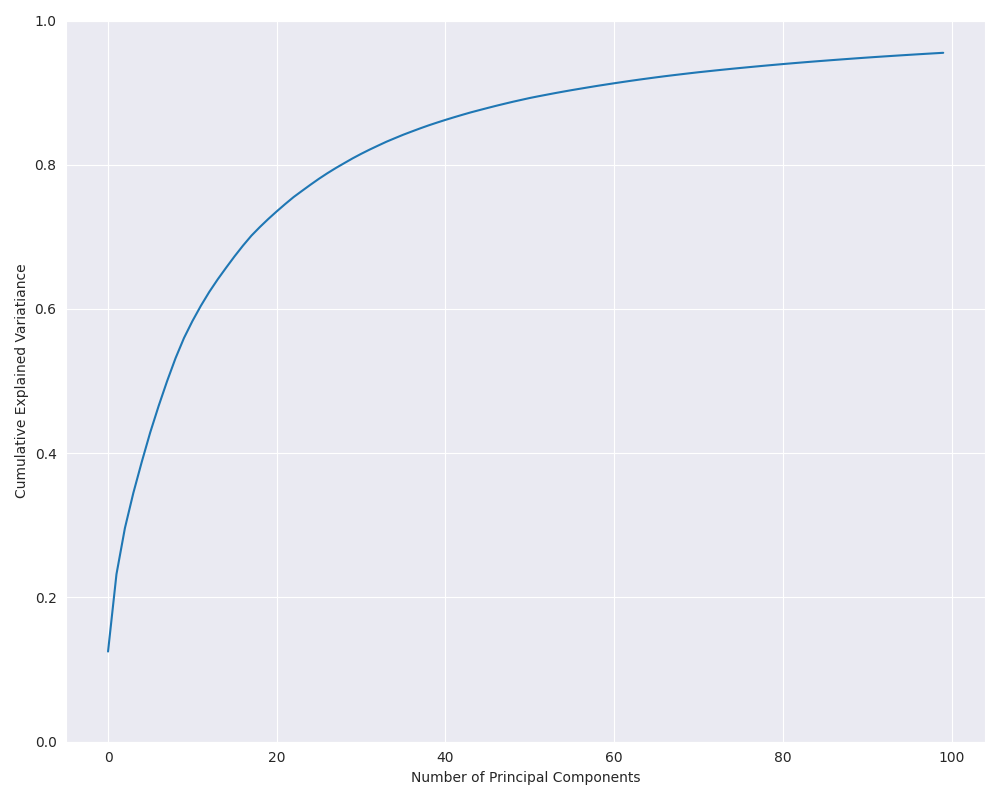

In [21]:
pca = PCA(n_components=100)
pca_result = pca.fit_transform(data_subset)

print(f"Cumulative explained variation for {len(pca.explained_variance_ratio_)} principal components: {np.sum(pca.explained_variance_ratio_)}")
plt.figure(figsize=(10,8))
plt.plot(np.arange(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))
plt.ylim([0, 1])
plt.ylabel('Cumulative Explained Variatiance')
plt.xlabel('Number of Principal Components')
plt.tight_layout()

## t-SNE

In [22]:
# t-SNE
tsne2d = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=3000)
tsne_result_2d = tsne2d.fit_transform(data_subset)

tsne3d = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=3000)
tsne_result_3d = tsne3d.fit_transform(data_subset)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 764 samples in 0.013s...
[t-SNE] Computed neighbors for 764 samples in 0.265s...
[t-SNE] Computed conditional probabilities for sample 764 / 764
[t-SNE] Mean sigma: 3.948701
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.074005
[t-SNE] KL divergence after 3000 iterations: 0.906169
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 764 samples in 0.013s...
[t-SNE] Computed neighbors for 764 samples in 0.280s...
[t-SNE] Computed conditional probabilities for sample 764 / 764
[t-SNE] Mean sigma: 3.948701
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.927559
[t-SNE] KL divergence after 3000 iterations: 1.165028


# Clustering

Number of clusters: 10
Homogeneity: 0.253
Completeness: 0.241
V-measure: 0.247
Adjusted Rand Index: 0.156
Adjusted Mutual Information: 0.226
Silhouette Coefficient: 0.189


<IPython.core.display.Javascript object>


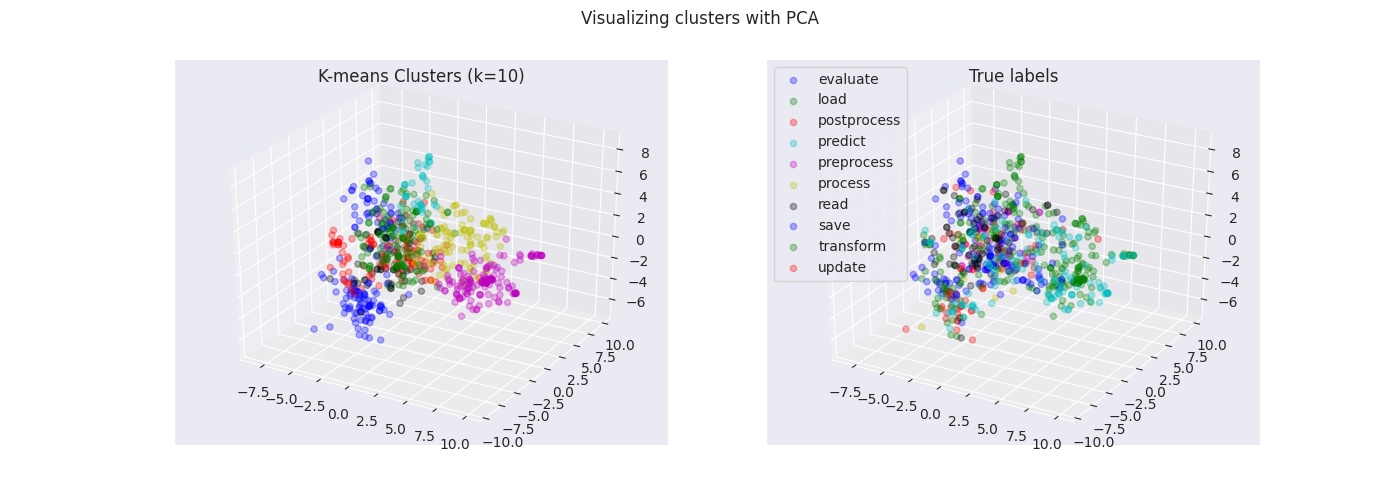

<IPython.core.display.Javascript object>


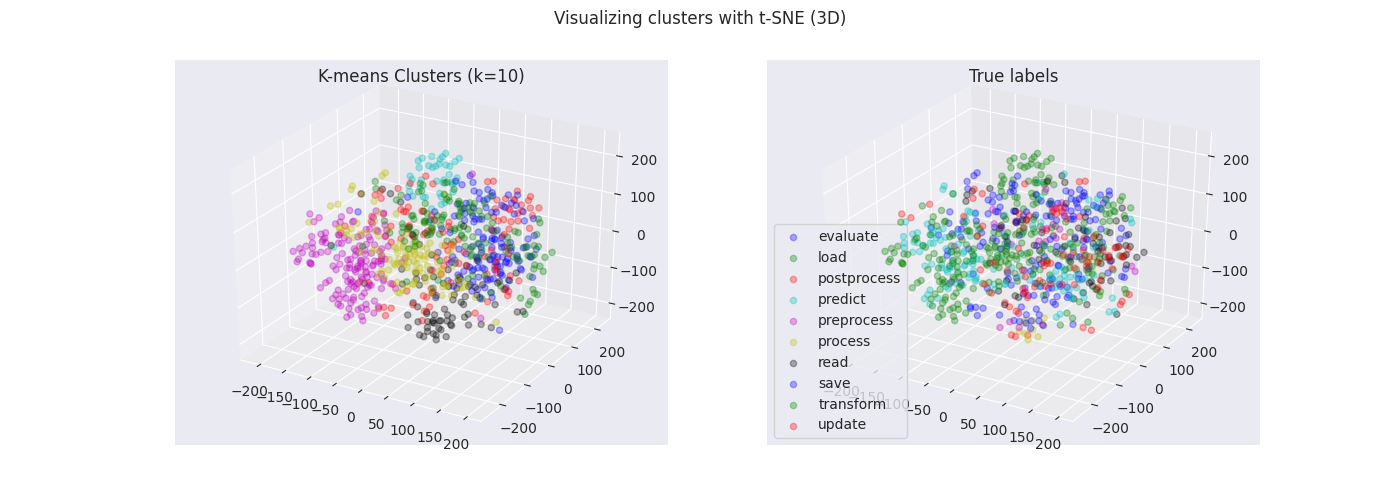

<IPython.core.display.Javascript object>


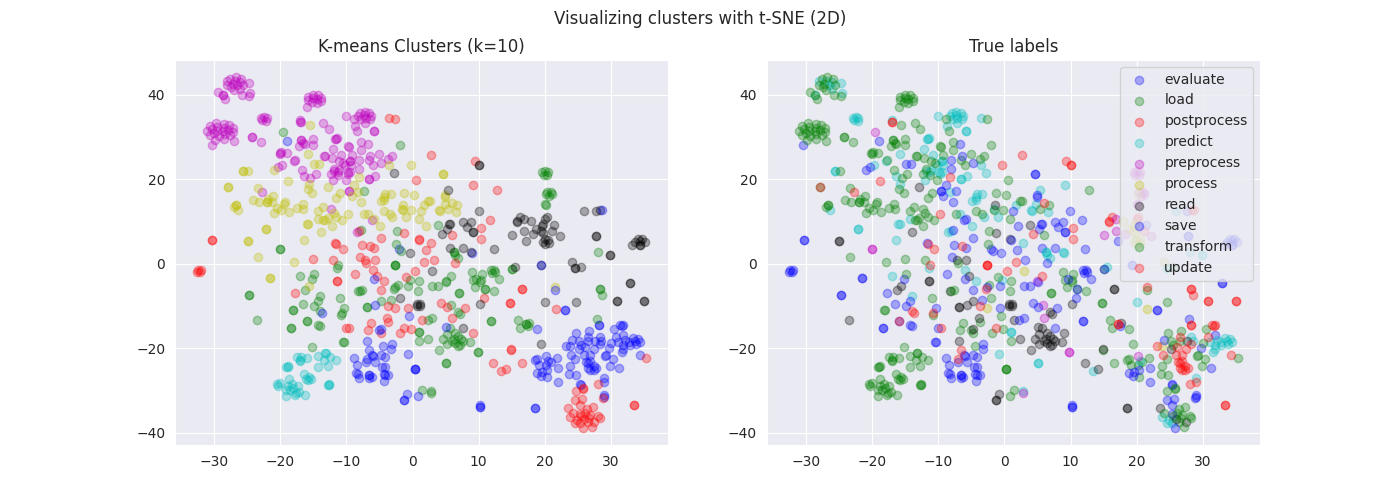

In [23]:
# Apply K-means
kmeans = KMeans(n_clusters=k, random_state=0).fit(data_subset)

print('Number of clusters: %d' % k)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df_subset['category'], kmeans.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(df_subset['category'], kmeans.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(df_subset['category'], kmeans.labels_))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(df_subset['category'], kmeans.labels_))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(df_subset['category'], kmeans.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(pca_result, kmeans.labels_, metric='sqeuclidean'))


# Try to visualize clusters using PCA
fig = plt.figure(figsize=(14,5))
fig.suptitle('Visualizing clusters with PCA')
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title(f'K-means Clusters (k={k})')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, k), colors):
    Xk = pca_result[kmeans.labels_ == klass]
    ax1.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], c=color, alpha=0.3)

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('True labels')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, k), colors):
    Xk = pca_result[df_subset['category'] == klass]
    ax2.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], c=color, alpha=0.3, label=unique_labels[klass])

ax2.legend()

# Try to visualize clusters using t-SNE in 3D
fig = plt.figure(figsize=(14,5))
fig.suptitle('Visualizing clusters with t-SNE (3D)')
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title(f'K-means Clusters (k={k})')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, k), colors):
    Xk = tsne_result_3d[kmeans.labels_ == klass]
    ax1.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], c=color, alpha=0.3, label=unique_labels[klass])


ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('True labels')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, k), colors):
    Xk = tsne_result_3d[df_subset['category'] == klass]
    ax2.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], c=color, alpha=0.3, label=unique_labels[klass])

ax2.legend()

# Try to visualize clusters using t-SNE in 2D
fig = plt.figure(figsize=(14,5))
fig.suptitle('Visualizing clusters with t-SNE (2D)')
ax1 = fig.add_subplot(121)
ax1.set_title(f'K-means Clusters (k={k})')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, k), colors):
    Xk = tsne_result_2d[kmeans.labels_ == klass]
    ax1.scatter(Xk[:, 0], Xk[:, 1], c=color, alpha=0.3, label=unique_labels[klass])


ax2 = fig.add_subplot(122)
ax2.set_title('True labels')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, k), colors):
    Xk = tsne_result_2d[df_subset['category'] == klass]
    ax2.scatter(Xk[:, 0], Xk[:, 1], c=color, alpha=0.3, label=unique_labels[klass])
    
ax2.legend()

---------- METRICS FOR OPTICS ----------
Number of clusters: 15
Homogeneity: 0.133
Completeness: 0.232
V-measure: 0.169
Adjusted Rand Index: 0.007
Adjusted Mutual Information: 0.132
Silhouette Coefficient: -0.215
---------- METRICS FOR DBSCAN EPS 0.1 ----------
Number of clusters: 8
Homogeneity: 0.088
Completeness: 0.273
V-measure: 0.133
Adjusted Rand Index: -0.021
Adjusted Mutual Information: 0.102
Silhouette Coefficient: -0.185
---------- METRICS FOR DBSCAN EPS 0.5 ----------
Number of clusters: 2
Homogeneity: 0.038
Completeness: 0.129
V-measure: 0.059
Adjusted Rand Index: 0.038
Adjusted Mutual Information: 0.050
Silhouette Coefficient: 0.150


<IPython.core.display.Javascript object>


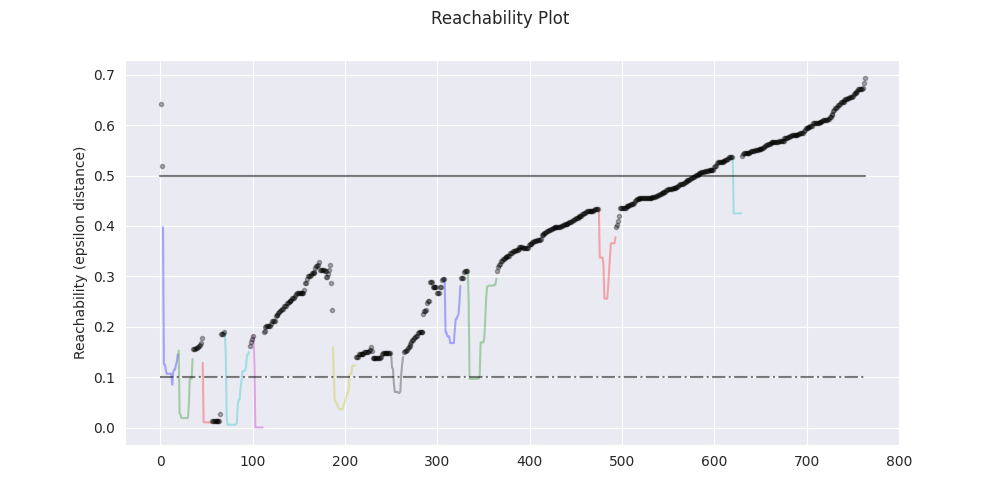

<IPython.core.display.Javascript object>


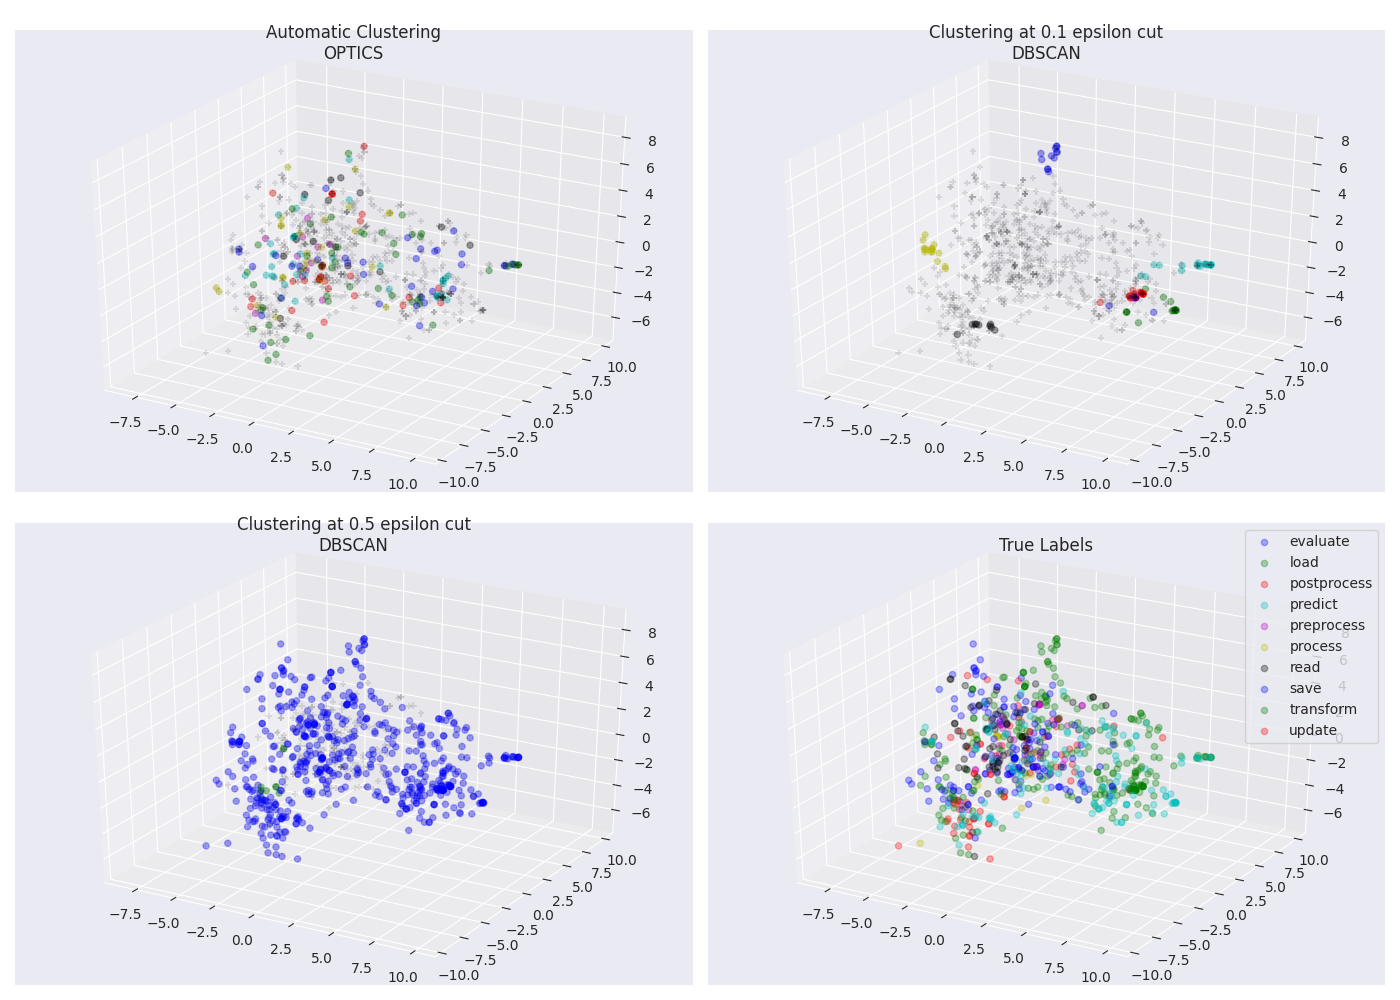

In [24]:
# Apply OPTICS algorithm
eps = [0.1, 0.5]
model = OPTICS(cluster_method='xi', min_samples=10, metric='cosine')
model.fit(data_subset)

labels_eps0 = cluster_optics_dbscan(reachability=model.reachability_,
                                   core_distances=model.core_distances_,
                                   ordering=model.ordering_, eps=eps[0])
labels_eps1 = cluster_optics_dbscan(reachability=model.reachability_,
                                   core_distances=model.core_distances_,
                                   ordering=model.ordering_, eps=eps[1])

space = np.arange(len(data_subset))
reachability = model.reachability_[model.ordering_]
optics_labels = model.labels_[model.ordering_]


print(f'{"-"*10} METRICS FOR OPTICS {"-"*10}')
print('Number of clusters: %d' % len(model.cluster_hierarchy_))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df_subset['category'], optics_labels))
print("Completeness: %0.3f" % metrics.completeness_score(df_subset['category'], optics_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(df_subset['category'], optics_labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(df_subset['category'], optics_labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(df_subset['category'], optics_labels))
if (len(model.cluster_hierarchy_) > 1):
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(data_subset, optics_labels, metric='sqeuclidean'))

print(f'{"-"*10} METRICS FOR DBSCAN EPS {eps[0]} {"-"*10}')
print('Number of clusters: %d' % len(np.unique(labels_eps0[labels_eps0 > -1])))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df_subset['category'], labels_eps0))
print("Completeness: %0.3f" % metrics.completeness_score(df_subset['category'], labels_eps0))
print("V-measure: %0.3f" % metrics.v_measure_score(df_subset['category'], labels_eps0))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(df_subset['category'], labels_eps0))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(df_subset['category'], labels_eps0))
if (len(np.unique(labels_eps0[labels_eps0 > -1])) > 1):
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(data_subset, labels_eps0, metric='sqeuclidean'))

print(f'{"-"*10} METRICS FOR DBSCAN EPS {eps[1]} {"-"*10}')
print('Number of clusters: %d' % len(np.unique(labels_eps1[labels_eps1 > -1])))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df_subset['category'], labels_eps1))
print("Completeness: %0.3f" % metrics.completeness_score(df_subset['category'], labels_eps1))
print("V-measure: %0.3f" % metrics.v_measure_score(df_subset['category'], labels_eps1))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(df_subset['category'], labels_eps1))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(df_subset['category'], labels_eps1))
if (len(np.unique(labels_eps1[labels_eps1 > -1])) > 1):
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(data_subset, labels_eps1, metric='sqeuclidean'))


labels = ['N/A']
for val in unique_labels.values():
    labels.append(val)

# Reachability plot
plt.figure(figsize=(10, 5))
plt.suptitle('Reachability Plot')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, len(model.cluster_hierarchy_)), colors):
    Xk = space[optics_labels == klass]
    Rk = reachability[optics_labels == klass]
    plt.plot(Xk, Rk, color, alpha=0.3)
plt.plot(space[optics_labels == -1], reachability[optics_labels == -1], 'k.', alpha=0.3)
plt.plot(space, np.full_like(space, eps[0], dtype=float), 'k-.', alpha=0.5)
plt.plot(space, np.full_like(space, eps[1], dtype=float), 'k-', alpha=0.5)
plt.ylabel('Reachability (epsilon distance)')



# Scatter plots
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(221, projection='3d')
ax1.set_title('Automatic Clustering\nOPTICS')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
ax1.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c='k', marker='+', alpha=0.1)
for klass, color in zip(range(0, len(model.cluster_hierarchy_)), colors):
    Xk = pca_result[optics_labels == klass]
    ax1.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], c=color, alpha=0.3)
    
ax2 = fig.add_subplot(222, projection='3d')
ax2.set_title(f'Clustering at {eps[0]} epsilon cut\nDBSCAN')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
ax2.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c='k', marker='+', alpha=0.1)
for klass, color in zip(range(0, len(np.unique(labels_eps0))), colors):
    Xk = pca_result[labels_eps0 == klass]
    ax2.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], c=color, alpha=0.3)
    

ax3 = fig.add_subplot(223, projection='3d')
ax3.set_title(f'Clustering at {eps[1]} epsilon cut\nDBSCAN')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
ax3.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c='k', marker='+', alpha=0.1)
for klass, color in zip(range(0, len(np.unique(labels_eps1)), colors):
    Xk = pca_result[labels_eps1 == klass]
    ax3.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], c=color, alpha=0.3)


ax4 = fig.add_subplot(224, projection='3d')
ax4.set_title('True Labels')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, k), colors):
    Xk = pca_result[df_subset['category'] == klass]
    ax4.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], c=color, alpha=0.3, label=unique_labels[klass])
ax4.legend()
plt.tight_layout()

## OPTICS with t-SNE (2D)

<IPython.core.display.Javascript object>


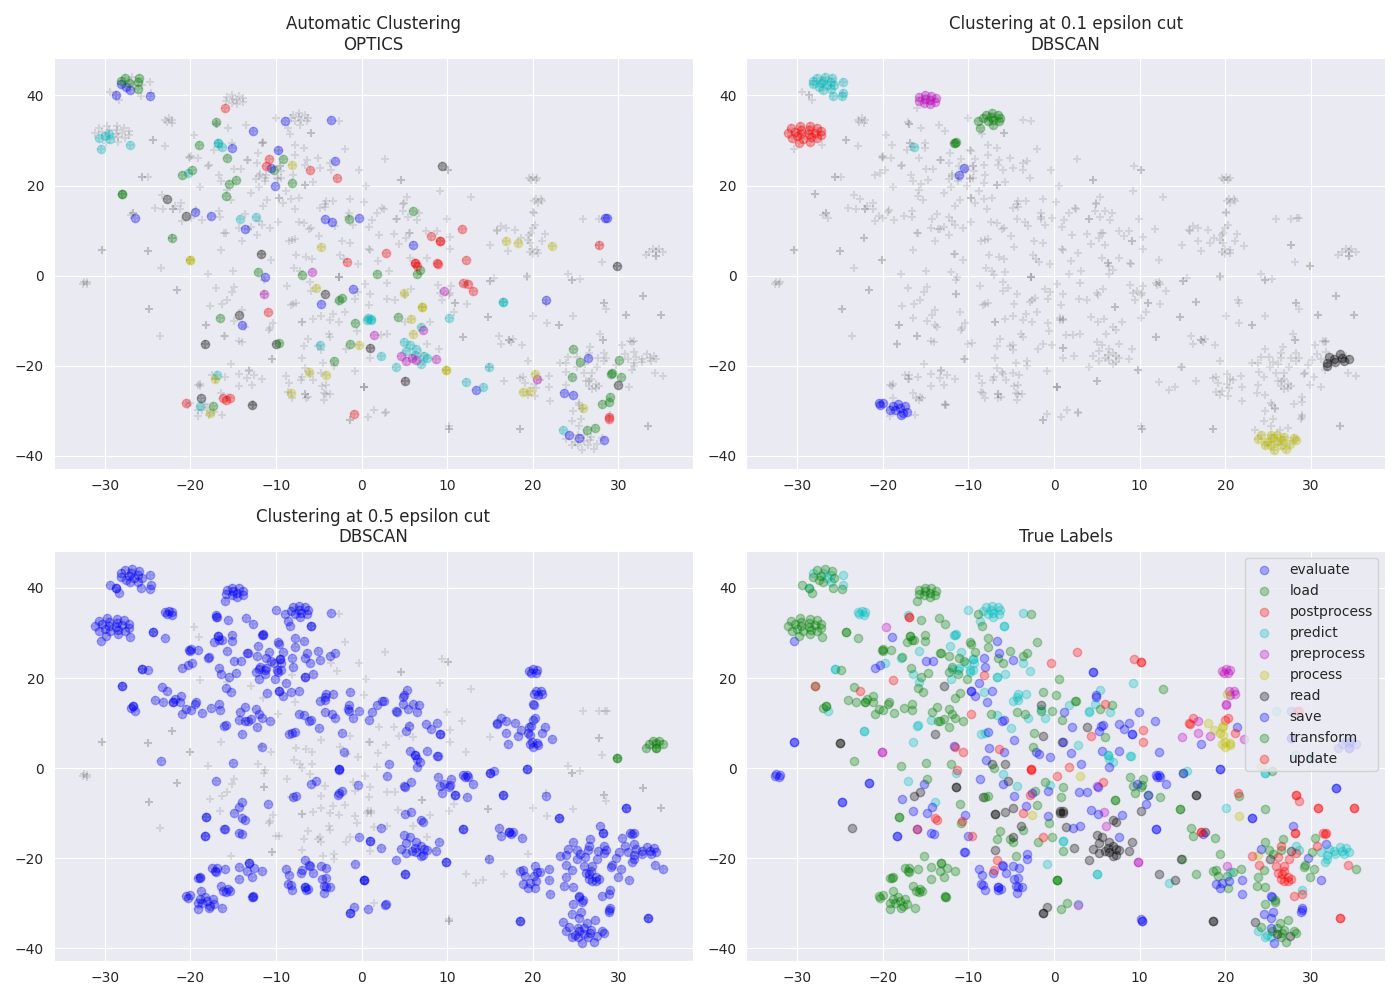

In [25]:
# Scatter plots
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(221)
ax1.set_title('Automatic Clustering\nOPTICS')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
ax1.scatter(tsne_result_2d[:, 0], tsne_result_2d[:, 1], c='k', marker='+', alpha=0.1)
for klass, color in zip(range(0, len(model.cluster_hierarchy_)), colors):
    Xk = tsne_result_2d[optics_labels == klass]
    ax1.scatter(Xk[:, 0], Xk[:, 1], c=color, alpha=0.3)
    
ax2 = fig.add_subplot(222)
ax2.set_title(f'Clustering at {eps[0]} epsilon cut\nDBSCAN')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
ax2.scatter(tsne_result_2d[:, 0], tsne_result_2d[:, 1], c='k', marker='+', alpha=0.1)
for klass, color in zip(range(0, k), colors):
    Xk = tsne_result_2d[labels_eps0 == klass]
    ax2.scatter(Xk[:, 0], Xk[:, 1], c=color, alpha=0.3)
    

ax3 = fig.add_subplot(223)
ax3.set_title(f'Clustering at {eps[1]} epsilon cut\nDBSCAN')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
ax3.scatter(tsne_result_2d[:, 0], tsne_result_2d[:, 1], c='k', marker='+', alpha=0.1)
for klass, color in zip(range(0, k), colors):
    Xk = tsne_result_2d[labels_eps1 == klass]
    ax3.scatter(Xk[:, 0], Xk[:, 1], c=color, alpha=0.3)


ax4 = fig.add_subplot(224)
ax4.set_title('True Labels')
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for klass, color in zip(range(0, k), colors):
    Xk = tsne_result_2d[df_subset['category'] == klass]
    ax4.scatter(Xk[:, 0], Xk[:, 1], c=color, alpha=0.3, label=unique_labels[klass])
ax4.legend()
plt.tight_layout()